In [1]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neural_network import  MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns


c:\Users\Victor\Universidad 2025-1\Introducción a la ciencia de datos\proyecto-4-ciencia-datos-repo\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparación inicial de los datos

In [2]:
df = pd.read_csv('../data/processed/2.1-student_habits_performance_estandarizado.csv')
df = df.drop(['student_id'], axis=1)
df

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,0.857143,0,0.000000,0.214286,0.239130,0,0.629630,0.727273,1.0,6,2.0,1.0,7,1,0.406504
1,0.428571,0,0.920000,0.500000,0.500000,0,0.933333,0.212121,2.0,6,0.0,1.0,7,0,1.000000
2,0.571429,1,0.186667,0.553571,0.282609,0,0.871605,0.727273,0.0,1,0.0,0.0,0,0,0.109756
3,0.857143,0,0.133333,0.696429,0.217391,0,0.283951,0.909091,0.0,4,2.0,2.0,0,1,0.008130
4,0.285714,0,0.666667,0.785714,0.108696,0,0.775309,0.257576,1.0,3,2.0,2.0,0,0,0.544715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,0.571429,0,0.346667,0.089286,0.347826,0,0.432099,0.651515,1.0,2,0.0,2.0,5,1,0.676152
936,0.000000,0,0.386667,0.178571,0.521739,1,0.654321,0.545455,0.0,1,0.0,1.0,5,1,0.537940
937,0.428571,1,0.400000,0.464286,0.282609,0,0.059259,0.500000,2.0,5,1.0,2.0,8,1,0.517615
938,1.000000,1,0.720000,0.732143,0.239130,1,1.000000,0.666667,1.0,0,1.0,1.0,0,0,0.589431


In [3]:
# separo en X & y
X = df.drop(['exam_score'], axis=1)
y = df['exam_score']

In [4]:
X.head(3)

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation
0,0.857143,0,0.000000,0.214286,0.239130,0,0.629630,0.727273,1.0,6,2.0,1.0,7,1
1,0.428571,0,0.920000,0.500000,0.500000,0,0.933333,0.212121,2.0,6,0.0,1.0,7,0
2,0.571429,1,0.186667,0.553571,0.282609,0,0.871605,0.727273,0.0,1,0.0,0.0,0,0


In [5]:
y.head(3)

0    0.406504
1    1.000000
2    0.109756
Name: exam_score, dtype: float64

### Prueba de K-fold cross validation con regresión lineal

In [6]:
lr_regressor = LinearRegression()

In [7]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [8]:
scores = cross_val_score(lr_regressor, X, y, cv=kf, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(lr_regressor, X, y, cv=kf, scoring='r2')

In [9]:
# Convertimos a RMSE
rmse_scores = np.sqrt(-scores)

print("RMSE por fold:", rmse_scores)
print("RMSE promedio:", rmse_scores.mean())

print("R2 por fold:", scores_r2)

RMSE por fold: [0.06765806 0.08115931 0.07444814 0.06015917 0.07602253 0.07562367
 0.06714554 0.07398151 0.07388667 0.0657427 ]
RMSE promedio: 0.07158273176715027
R2 por fold: [0.91446494 0.88644181 0.90100885 0.91086883 0.8993839  0.88163371
 0.9071379  0.90514754 0.87880115 0.91781783]


#### Visualizar los folds de cross validation

In [10]:
def plot_kfold_cv(X, n_splits=10):
    plt.figure(figsize=(12, 6))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    n_samples = len(X)
    indices = np.arange(n_samples)  # solo para graficar el índice

    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Graficar puntos azules para entrenamiento
        plt.scatter(train_idx, [i + 1] * len(train_idx), 
                    c='blue', s=20, label='Train' if i == 0 else "")
        
        # Rojos para validación
        plt.scatter(val_idx, [i + 1] * len(val_idx), 
                    c='red', s=20, label='Validation' if i == 0 else "")

    plt.yticks(range(1, n_splits + 1))
    plt.xlabel('Índice de muestra')
    plt.ylabel('Fold')
    plt.title(f'{n_splits}-Fold Cross Validation Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()

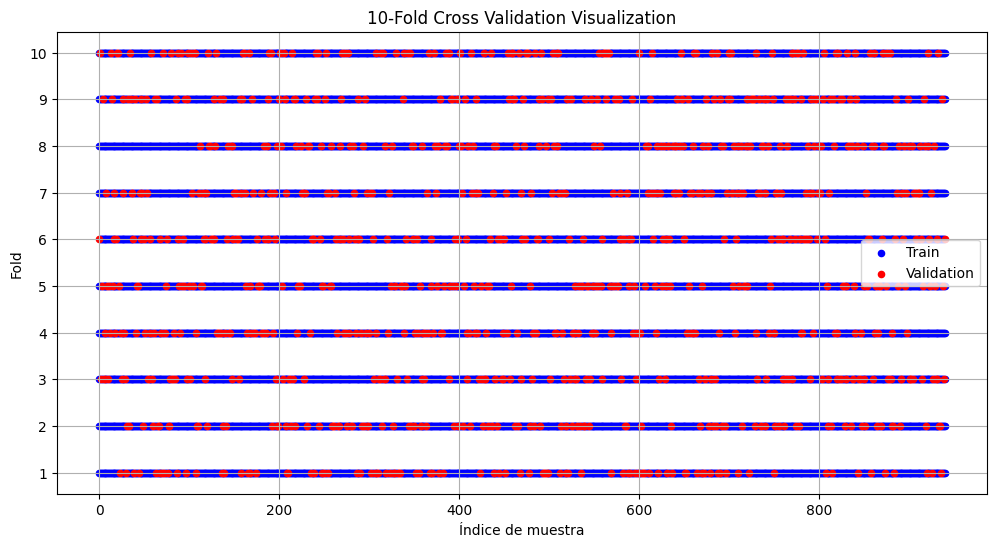

In [11]:
plot_kfold_cv(X, n_splits=10)

## Creación y prueba de modelos de regresión (Uso de Optuna para hiperparametros)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# lista para almacenar los graficos
figures = []

### Random Forest Regressor

In [14]:
# se definen los hiperparámetros a optimizar en esta función
def objective(trial):
    # hiperparametros a optimizar (ej: entre 50 y 200)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # crear el modelo
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    # defino el cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    scores_mse = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

    mse_mean = -scores_mse.mean()
    return mse_mean  # minimizamos mse (se puede hacer con r2)

In [15]:
# optimizacion
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-06-16 07:26:25,592] A new study created in memory with name: no-name-ffdeeba5-0d80-4d36-a91e-a9e5b0e78564
[I 2025-06-16 07:26:26,509] Trial 0 finished with value: 0.014978139257697056 and parameters: {'n_estimators': 78, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.014978139257697056.
[I 2025-06-16 07:26:29,312] Trial 1 finished with value: 0.012773567539395935 and parameters: {'n_estimators': 208, 'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.012773567539395935.
[I 2025-06-16 07:26:30,106] Trial 2 finished with value: 0.013418958723450761 and parameters: {'n_estimators': 62, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.012773567539395935.
[I 2025-06-16 07:26:31,524] Trial 3 finished with value: 0.0124

In [16]:
# mejores parametros encontrados y sus resultados
print("\nMejores parámetros encontrados para Random Forest:")
print(study.best_params)
print("Mejor MSE:", study.best_value)


Mejores parámetros encontrados para Random Forest:
{'n_estimators': 245, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Mejor MSE: 0.007481645433762464


In [17]:
# entreno el modelo con los mejores parámetros
best_model_rf_reg = RandomForestRegressor(**study.best_params, random_state=42)
best_model_rf_reg.fit(X_train, y_train)

,n_estimators,245
,criterion,'squared_error'
,max_depth,29
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
# evaluación del modelo
y_pred_rf = best_model_rf_reg.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)

r2_rf = r2_score(y_test, y_pred_rf)

print("\nEvaluación del Modelo de Regresión:")
print(f"Random Forest Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")

# importancia de variables
importances_rf = best_model_rf_reg.feature_importances_


Evaluación del Modelo de Regresión:
Random Forest Mean Squared Error (MSE): 0.0075
Random Forest R² Score: 0.8661


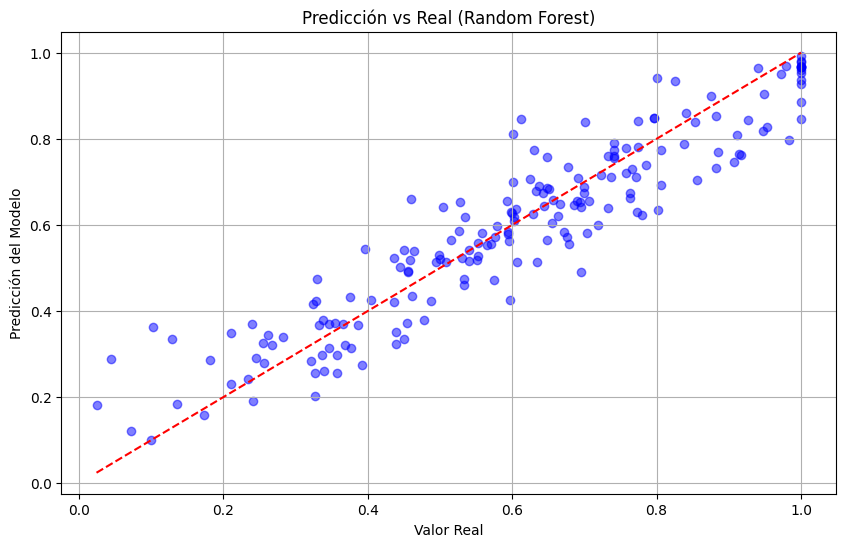

In [19]:
# grafico
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicción vs Real (Random Forest)')
plt.xlabel('Valor Real')
plt.ylabel('Predicción del Modelo')
plt.grid(True)
plt.show()


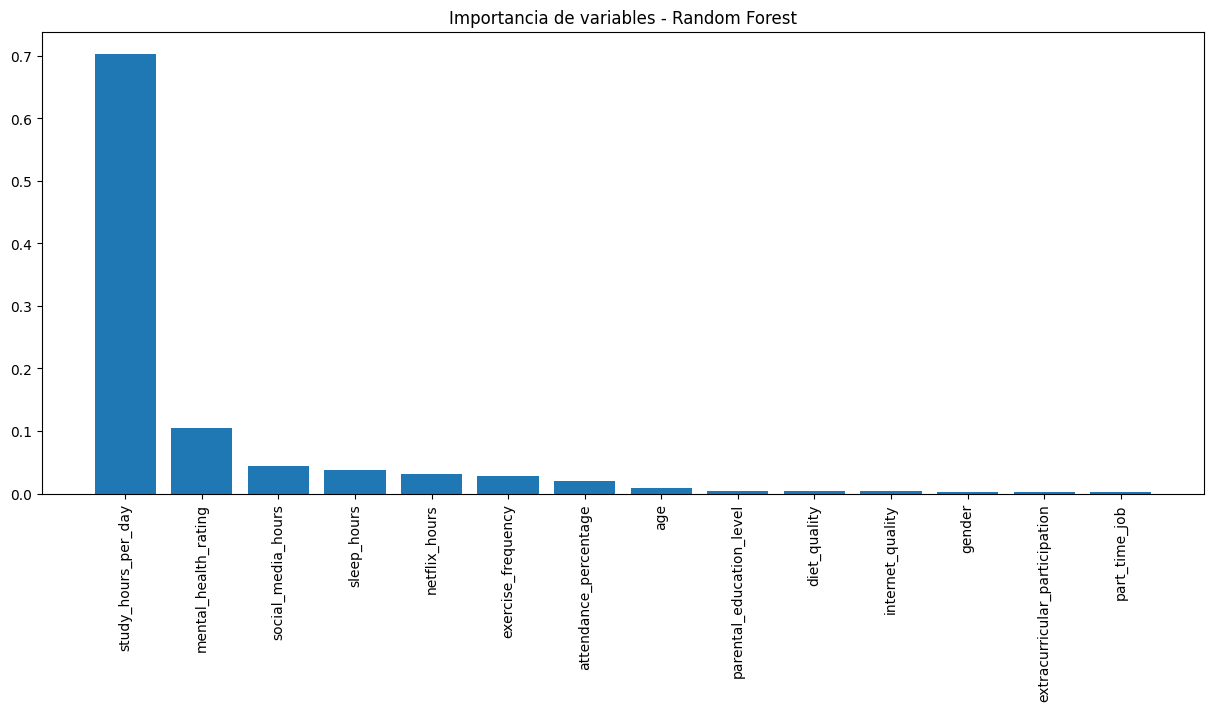

In [20]:
# importancia de variables en el modelo
feature_names = X_train.columns

indices_rf = np.argsort(importances_rf)[::-1]  # Orden descendente
plt.figure(figsize=(15, 6))
plt.title("Importancia de variables - Random Forest")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices_rf], rotation=90)
plt.show()

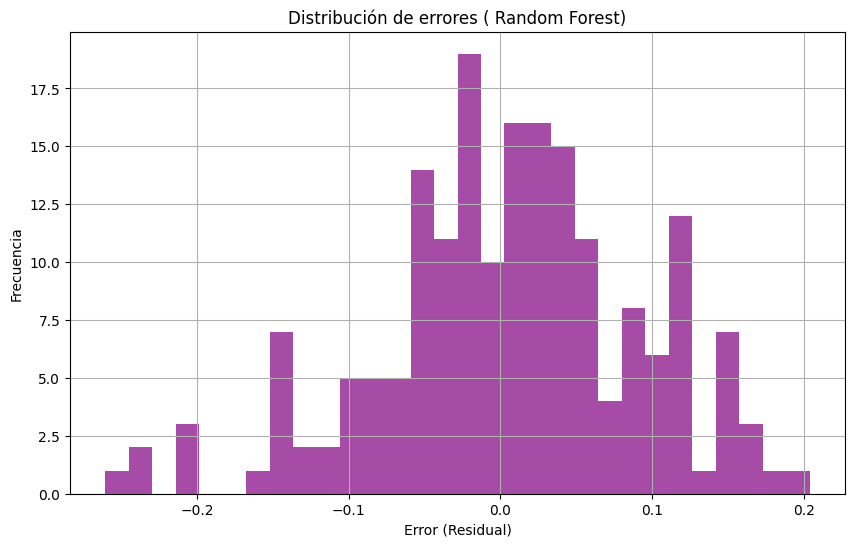

In [ ]:
# gráfica de errores
errors_rf = y_test - y_pred_rf

fig_rf, ax_rf = plt.subplots(figsize=(10, 6))

ax_rf.hist(errors_rf, bins=30, color='purple',  alpha=0.7)
ax_rf.set_title('Distribución de errores ( Random Forest)')
ax_rf.set_xlabel('Error (Residual)')
ax_rf.set_ylabel('Frecuencia')
ax_rf.grid(True)